# Teen Age Pregnancy Rates Data Modeling Study

## Imports and data ingestion

In [4]:
#loading imports

import pandas as pd
import seaborn as sns
import numpy as np
import notebook_toolkit as nt
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from itertools import combinations, product
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import pylab as py 

#setting environment, importing helper scripts and variables

%matplotlib inline
nt.set_environment()
%run variables.py

#importing data
raw_df = pd.read_csv("analytic_data2019.csv")

# Data Cleanup

In [5]:
#function to remove columns from the dataframe that are not needed for analysis based on keywords

working_df = nt.drop_column_keyword_search(raw_df, keywords)

In [6]:
#function to identify and drop columns with more than 10% of their data missing

ten_percent_missing_values_columns = nt.column_null_percentage(working_df)
working_df = working_df.drop(columns = ten_percent_missing_values_columns.index)
working_df = working_df.drop(0)

In [11]:
#converting non-categorical variables to floats and ensuring that categorical variables are strings

string_datatype_df = working_df.iloc[:, 0:4]
float_datatype_df = working_df.iloc[:, 5:].astype(float)
working_df = pd.concat([string_datatype_df, float_datatype_df], axis = 1)

In [12]:
#create a new data frame for data at the state and national level and make sure it is indexed correctly

non_county_df = working_df[working_df[ranked].isnull()]
non_county_df.reset_index(inplace = True)
del non_county_df["index"], non_county_df[ranked]

In [13]:
#create a new data frame for data at the county level and make sure it is indexed correctly

county_level_df = working_df[working_df[ranked].notnull()]
county_level_df.reset_index(inplace = True)
del county_level_df["index"], county_level_df[ranked]

In [14]:
#fill missing data in the county level dataframe with the columns median values

county_level_df = county_level_df.fillna(county_level_df.median())

In [15]:
#fill missing data in the non-county level dataframe with the column median values

non_county_df[free_lunch] = non_county_df[free_lunch].fillna(non_county_df[free_lunch].median())

In [10]:
#delete irrelavent columns from non-county level dataframe

del non_county_df[housing_costs], non_county_df[overcrowding]
del non_county_df[facilities], non_county_df[release_year]

In [10]:
#fill in isolated missing values in the non-county level dataframe

non_county_df.iloc[2,35] = non_county_df.iloc[:,35].median()
non_county_df.iloc[12,35] = non_county_df.iloc[:,35].median()
non_county_df.iloc[12,36] = non_county_df.iloc[:,36].median()
non_county_df = non_county_df.fillna(non_county_df.mean())

In [11]:
#create a national level and state level dataframe. We only used the country level dataframe in the analysis

national_level_df = non_county_df.iloc[0]
state_level_df = non_county_df.iloc[1:,:]

In [16]:
#create and EDA dataframe from county level and drop more irrelavent columns

eda_df = county_level_df.copy()
eda_df = eda_df.drop(columns = ['Drinking water violations raw value', '% Asian raw value'])

In [17]:
#function to return a list of columns that correlate greater the 0.75 so that they can be removed to avoid colinearity

to_drop = nt.multicolinear_drop(eda_df)

In [18]:
#drop coliear features from the EDA dataframe

eda_df = eda_df.drop(eda_df[to_drop], axis =1)

In [19]:
#create a clean_df that contains features that have been manually chosen to be part of the analysis

clean_df = eda_df[features]

# Modeling

In [23]:
#create a dataframe of non-categorical predictor variables for our model

x_df = clean_df.drop(columns = ['Teen births raw value',
                                'State FIPS Code', 
                                'County FIPS Code', 
                                '5-digit FIPS Code',
                                'State Abbreviation'])

In [24]:
#create a dataframe of the target variable for our model

y_df = clean_df['Teen births raw value']


In [25]:
# splitting the dataset into training and testing sets, ensuring we have at least 1,000 rows in our test dataset

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.35, random_state=42)

In [27]:
#create a simple baseline model using a simple linear regression and K Fold cross validation  (7 folds) 

regression = LinearRegression()

crossvalidation = KFold(n_splits=7, shuffle=True, random_state=42)
baseline_model = cross_validate(
    regression, X_train, y_train, scoring='r2', cv=crossvalidation, return_train_score = True)
baseline_model

{'fit_time': array([0.03583884, 0.00995922, 0.00687218, 0.00572896, 0.00408506,
        0.00420284, 0.00367689]),
 'score_time': array([0.00303698, 0.00283813, 0.00304508, 0.00312614, 0.00137901,
        0.0016892 , 0.00136113]),
 'test_score': array([0.68049585, 0.68074466, 0.72255543, 0.71589002, 0.6854858 ,
        0.70126346, 0.71068984]),
 'train_score': array([0.71554074, 0.71679552, 0.71044232, 0.71059558, 0.7164024 ,
        0.71340629, 0.71157067])}

In [29]:
#our linear model has room to grow, so we test the improvements in R^2 that can be gained by using interactions 
#and polynomial terms from order 2 - order 4. The model below uses a simple regresion baseed on a simple regression
#as opposed to using cross_validate. This is intentional for simplicity

for index, degree in enumerate([2, 3, 4]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, reg_poly.score(X_poly_train, y_train))

degree 2 0.8154513940007526
degree 3 0.7303824247848552
degree 4 0.04525919103937959


As can be seen above there is an improvement that can be made by using 2nd order polynomial termsm but there is a sharp drop off in performance above that. Let's try making polynomial terms and see what happens.

In [31]:
#Normalise all data for use in more advanced models

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [33]:
# Build a linear regression using scaled data to see if it differs from unscaled?
#The answer is not really for linear regression

linreg_scaled = LinearRegression()
linreg_scaled.fit(X_train_scaled, y_train)

baseline_model_scaled = cross_validate(
    linreg_scaled, X_train_scaled, y_train, scoring='r2', cv=crossvalidation, return_train_score = True)

baseline_model_scaled


{'fit_time': array([0.00417805, 0.00419188, 0.00510716, 0.00327802, 0.00333905,
        0.00602293, 0.01580095]),
 'score_time': array([0.00118113, 0.00092411, 0.00107169, 0.00133014, 0.00093508,
        0.00115418, 0.00153494]),
 'test_score': array([0.68049585, 0.68074466, 0.72255543, 0.71589002, 0.6854858 ,
        0.70126346, 0.71068984]),
 'train_score': array([0.71554074, 0.71679552, 0.71044232, 0.71059558, 0.7164024 ,
        0.71340629, 0.71157067])}

In [36]:
#build a 2nd order polynomial regression dataset for predictors

poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train))
X_test_poly = pd.DataFrame(poly.fit_transform(X_test))

In [37]:
#build a linear regression using polynomial data 

linreg_poly = LinearRegression()
linreg_poly.fit(X_train_poly, y_train)

baseline_model_poly = cross_validate(
    linreg_poly, X_train_poly, y_train, scoring='r2', cv=crossvalidation, return_train_score = True)

baseline_model_poly

{'fit_time': array([0.06564212, 0.0538559 , 0.05559492, 0.05120707, 0.05454183,
        0.05370903, 0.05573988]),
 'score_time': array([0.00395799, 0.0025661 , 0.00219083, 0.00216484, 0.00253105,
        0.0020659 , 0.00217485]),
 'test_score': array([0.22551321, 0.61795243, 0.00959689, 0.47642144, 0.59486336,
        0.61903698, 0.43547553]),
 'train_score': array([0.82493316, 0.82708215, 0.80300283, 0.82367753, 0.81348019,
        0.75261332, 0.7947276 ])}

As can be seen this is massively overfitting, so lets try more advanced models (Ridge and Lasso) to see if we can get better results

In [38]:
#Normalise all polynomial data

ss = StandardScaler()
X_train_poly_scaled = ss.fit_transform(X_train_poly)
X_test_poly_scaled = ss.transform(X_test_poly)

## Lasso Regression

In [39]:
#run Lasso regressions incrementally using alpha's from 1 - 9 to see performance and output results

lasso_poly_train = []
lasso_poly_test = []
alphas = []

for alpha in range(0,10):

    lasso = Lasso(alpha) 
    lasso.fit(X_train_poly, y_train)

    lasso_model_poly = cross_validate(
    lasso, X_train_poly, y_train, scoring='r2', cv=crossvalidation, return_train_score = True)

    print(f"Lasso alpha = {lasso.alpha}")
    alphas.append(alpha)
    print()
    print(f'Lasso train score = {round(lasso_model_poly["train_score"].mean(),3)}')
    lasso_poly_train.append(round(lasso_model_poly["train_score"].mean(),3))
    print()
    print(f'Lasso test score = {round(lasso_model_poly["test_score"].mean(),3)}')
    lasso_poly_test.append(round(lasso_model_poly["test_score"].mean(),3))
    print()



Lasso alpha = 0

Lasso train score = 0.833

Lasso test score = 0.549

Lasso alpha = 1

Lasso train score = 0.734

Lasso test score = 0.305

Lasso alpha = 2

Lasso train score = 0.729

Lasso test score = 0.275

Lasso alpha = 3

Lasso train score = 0.725

Lasso test score = 0.261

Lasso alpha = 4

Lasso train score = 0.721

Lasso test score = 0.258

Lasso alpha = 5

Lasso train score = 0.718

Lasso test score = 0.256

Lasso alpha = 6

Lasso train score = 0.715

Lasso test score = 0.251

Lasso alpha = 7

Lasso train score = 0.713

Lasso test score = 0.242

Lasso alpha = 8

Lasso train score = 0.71

Lasso test score = 0.228

Lasso alpha = 9

Lasso train score = 0.707

Lasso test score = 0.211



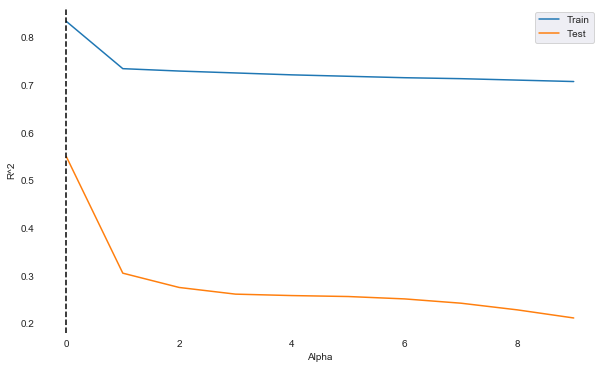

In [40]:
#plot the output of the Lasso test

fig, ax = plt.subplots(figsize=(10,6))
optimal_alpha = 0

ax.plot(alphas, lasso_poly_train, label='Train')
ax.plot(alphas, lasso_poly_test, label='Test')
ax.set_xlabel('Alpha')
ax.set_ylabel('R^2')
ax = plt.gca()
ax.set_facecolor('xkcd:white')
ax.axvline(optimal_alpha, color='black', linestyle='--')
ax.legend();



As can be seen the best result for Lasso is around alpha = 0; lets run another regression between 0 - 1 to see if there is any improvement

In [41]:
#run Lasso regressions incrementally using alpha's from 0 - 1 to see performance and output results

lasso_poly_train_decimal = []
lasso_poly_test_decimal = []
alphas_decimal = []

for alpha in np.linspace(0, 1, num=11):

    lasso = Lasso(alpha) 
    lasso.fit(X_train_poly, y_train)

    lasso_model_poly = cross_validate(
    lasso, X_train_poly, y_train, scoring='r2', cv=crossvalidation, return_train_score = True)

    print(f"Lasso alpha = {lasso.alpha}")
    alphas_decimal.append(alpha)
    print()
    print(f'Lasso train score = {round(lasso_model_poly["train_score"].mean(),3)}')
    lasso_poly_train_decimal.append(round(lasso_model_poly["train_score"].mean(),3))
    print()
    print(f'Lasso test score = {round(lasso_model_poly["test_score"].mean(),3)}')
    lasso_poly_test_decimal.append(round(lasso_model_poly["test_score"].mean(),3))
    print()

Lasso alpha = 0.0

Lasso train score = 0.833

Lasso test score = 0.549

Lasso alpha = 0.1

Lasso train score = 0.77

Lasso test score = 0.571

Lasso alpha = 0.2

Lasso train score = 0.759

Lasso test score = 0.519

Lasso alpha = 0.30000000000000004

Lasso train score = 0.754

Lasso test score = 0.48

Lasso alpha = 0.4

Lasso train score = 0.75

Lasso test score = 0.443

Lasso alpha = 0.5

Lasso train score = 0.745

Lasso test score = 0.4

Lasso alpha = 0.6000000000000001

Lasso train score = 0.74

Lasso test score = 0.357

Lasso alpha = 0.7000000000000001

Lasso train score = 0.737

Lasso test score = 0.331

Lasso alpha = 0.8

Lasso train score = 0.736

Lasso test score = 0.321

Lasso alpha = 0.9

Lasso train score = 0.735

Lasso test score = 0.311

Lasso alpha = 1.0

Lasso train score = 0.734

Lasso test score = 0.305



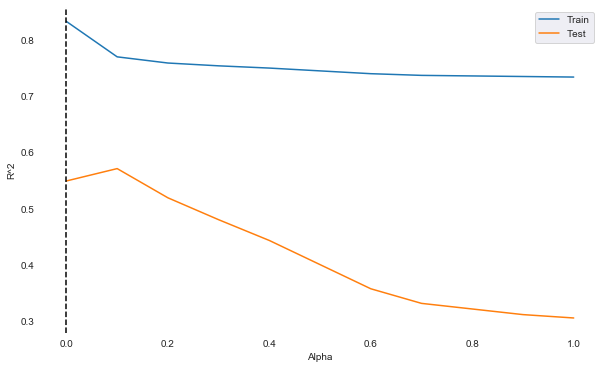

In [43]:
#plot the output of the Lasso test

fig, ax = plt.subplots(figsize=(10,6))
optimal_alpha = 0
ax.plot(alphas_decimal, lasso_poly_train_decimal, label='Train')
ax.plot(alphas_decimal, lasso_poly_test_decimal, label='Test')
ax.set_xlabel('Alpha')
ax.set_ylabel('R^2')
ax = plt.gca()
ax.set_facecolor('xkcd:white')
ax.axvline(optimal_alpha, color='black', linestyle='--')
ax.legend();

There is no real improvement over alpha = 0 for Lasso, so now lets run Ridge to see if we get an improvement

## Ridge Regression

In [45]:
#run Ridge regressions incrementally using alpha's from 1 - 9 to see performance and output results

ridge_poly_train = []
ridge_poly_test = []
alphas = []

for alpha in range(0,10):

    ridge = Ridge(alpha) 
    ridge.fit(X_train_poly, y_train)

    ridge_model_poly = cross_validate(
    ridge, X_train_poly, y_train, scoring='r2', cv=crossvalidation, return_train_score = True)

    print(f"Ridge alpha = {ridge.alpha}")
    alphas.append(alpha)
    print()
    print(f'Ridge train score = {round(ridge_model_poly["train_score"].mean(),3)}')
    ridge_poly_train.append(round(ridge_model_poly["train_score"].mean(),3))
    print()
    print(f'Ridge test score = {round(ridge_model_poly["test_score"].mean(),3)}')
    ridge_poly_test.append(round(ridge_model_poly["test_score"].mean(),3))
    print()


Ridge alpha = 0

Ridge train score = 0.827

Ridge test score = 0.506

Ridge alpha = 1

Ridge train score = 0.799

Ridge test score = 0.608

Ridge alpha = 2

Ridge train score = 0.796

Ridge test score = 0.611

Ridge alpha = 3

Ridge train score = 0.795

Ridge test score = 0.612

Ridge alpha = 4

Ridge train score = 0.794

Ridge test score = 0.612

Ridge alpha = 5

Ridge train score = 0.793

Ridge test score = 0.612

Ridge alpha = 6

Ridge train score = 0.792

Ridge test score = 0.611

Ridge alpha = 7

Ridge train score = 0.791

Ridge test score = 0.611

Ridge alpha = 8

Ridge train score = 0.791

Ridge test score = 0.61

Ridge alpha = 9

Ridge train score = 0.79

Ridge test score = 0.61



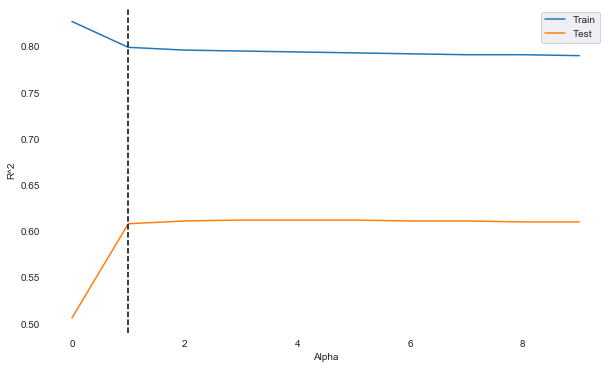

In [46]:
#plot the output of the Ridge test

fig, ax = plt.subplots(figsize=(10,6))
optimal_alpha = 1
ax.plot(alphas, ridge_poly_train, label='Train')
ax.plot(alphas, ridge_poly_test, label='Test')
ax.set_xlabel('Alpha')
ax.set_ylabel('R^2')
ax = plt.gca()
ax.set_facecolor('xkcd:white')
ax.axvline(optimal_alpha, color='black', linestyle='--')
ax.legend();

As can be seen the best result for Ridge is around alpha = 01 lets run another regression between 0 - 1 to see if there is any improvement

In [47]:
#run Ridge regressions incrementally using alpha's from 0 - 1 to see performance and output results

ridge_poly_train_decimal = []
ridge_poly_test_decimal = []
alphas_decimal = []

for alpha in np.linspace(0, 1, num=11):

    ridge = Ridge(alpha) 
    lasso.fit(X_train_poly, y_train)

    ridge_model_poly = cross_validate(
    ridge, X_train_poly, y_train, scoring='r2', cv=crossvalidation, return_train_score = True)

    print(f"Ridge alpha = {ridge.alpha}")
    alphas_decimal.append(alpha)
    print()
    print(f'Ridge train score = {round(ridge_model_poly["train_score"].mean(),3)}')
    ridge_poly_train_decimal.append(round(ridge_model_poly["train_score"].mean(),3))
    print()
    print(f'Ridge test score = {round(ridge_model_poly["test_score"].mean(),3)}')
    ridge_poly_test_decimal.append(round(ridge_model_poly["test_score"].mean(),3))
    print()

Ridge alpha = 0.0

Ridge train score = 0.827

Ridge test score = 0.506

Ridge alpha = 0.1

Ridge train score = 0.808

Ridge test score = 0.585

Ridge alpha = 0.2

Ridge train score = 0.805

Ridge test score = 0.592

Ridge alpha = 0.30000000000000004

Ridge train score = 0.803

Ridge test score = 0.596

Ridge alpha = 0.4

Ridge train score = 0.802

Ridge test score = 0.599

Ridge alpha = 0.5

Ridge train score = 0.801

Ridge test score = 0.601

Ridge alpha = 0.6000000000000001

Ridge train score = 0.8

Ridge test score = 0.603

Ridge alpha = 0.7000000000000001

Ridge train score = 0.8

Ridge test score = 0.605

Ridge alpha = 0.8

Ridge train score = 0.799

Ridge test score = 0.606

Ridge alpha = 0.9

Ridge train score = 0.799

Ridge test score = 0.607

Ridge alpha = 1.0

Ridge train score = 0.799

Ridge test score = 0.608



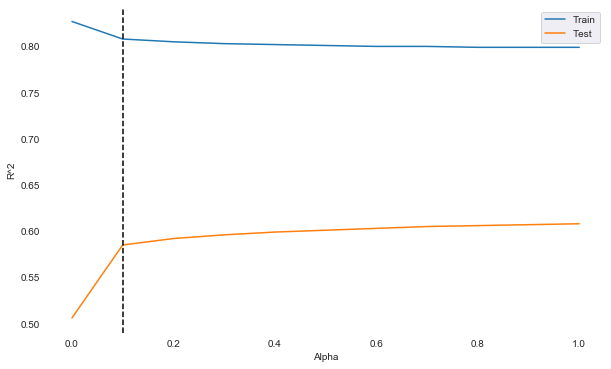

In [48]:
#plot the output of the Ridge test

fig, ax = plt.subplots(figsize=(10,6))
optimal_alpha = 0.1
ax.plot(alphas_decimal, ridge_poly_train_decimal, label='Train')
ax.plot(alphas_decimal, ridge_poly_test_decimal, label='Test')
ax.set_xlabel('Alpha')
ax.set_ylabel('R^2')
ax = plt.gca()
ax.set_facecolor('xkcd:white')
ax.axvline(optimal_alpha, color='black', linestyle='--')
ax.legend();

As can be seen above the best result is for Ridge regression using 2nd order polynomials and alpha = 1. Let's build a final model based on this

## Final Model

In [49]:
#final model intialisation

final_model_ridge = Ridge(1)
final_model = final_model_ridge.fit(X_train_poly, y_train)

In [51]:
#create a sorted dataframe of the coefficients in the model to identify trends

coefficients = pd.DataFrame(final_model_ridge.coef_, poly.get_feature_names(X_train.columns))
coefficients = coefficients.rename(columns = {0 : "Coefficients"})
coefficients = coefficients.sort_values(by = "Coefficients", ascending = False);
coeffcient_strength = coefficients.head(10)

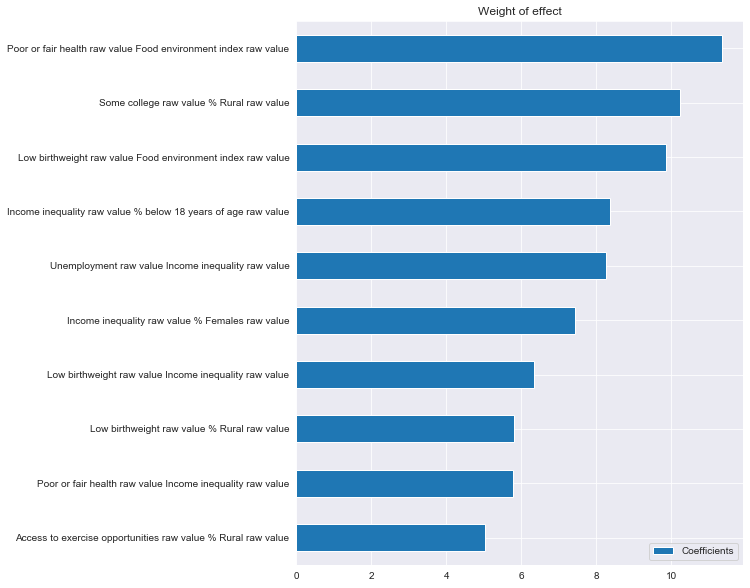

In [52]:
#plot a top 10 list of the weight of coefficients in order to identify trends

plt.rcParams['figure.figsize'] = (8.0, 10.0)
coeffcient_strength.plot(kind = "barh")
plt.title("Weight of effect")
plt.gca().invert_yaxis()

## Model Sanity Checks

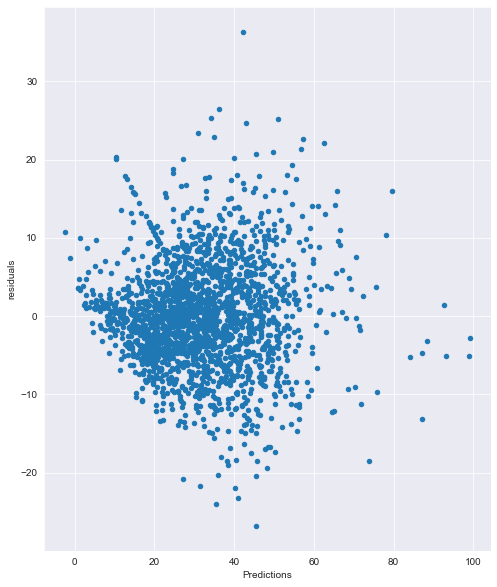

In [57]:
# Create a dataframe of residuals for the X_train dataset and plot a scatterplot to check for homoscedasticity

train_residuals = pd.DataFrame({"Predictions":final_model.predict(X_train_poly), "True_value":y_train})
data = train_residuals["residuals"] = train_residuals["True_value"] - train_residuals["Predictions"]
train_residuals.plot(x="Predictions", y="residuals",kind = "scatter");

The scatter plot above of residuals versus predictions shows a fairly random 'cloud' pattern suggesting the  homoscedasticity condition is fulfilled. 

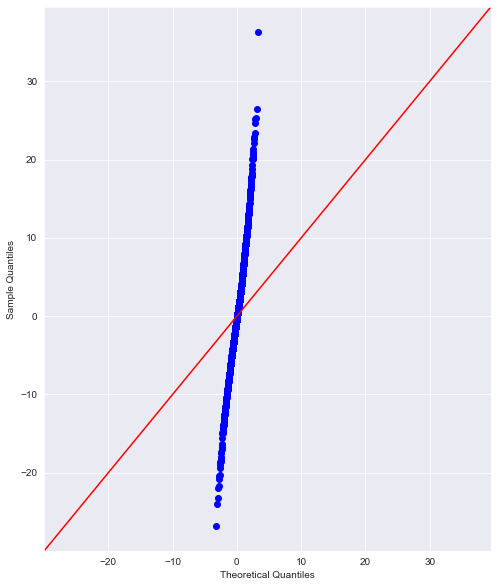

In [58]:
#create a QQ plot of residuals to test for normality condition

sm.qqplot(data, line ='45') 
py.show() 

As can be seen the QQ plot line is straight, however it is going in the wrong direction, which is incongruent with what we are seeing in the scatterplot. It would be good to have some steer on possible for reasons for this.

## Final Model Validation

In [62]:
print('Summary of final model for training and test sets')
print('-------------------------------------------------')
final_model.fit(X_train, y_train)
print('Training r^2:', final_model.score(X_train, y_train))
print('--------------------------------------------------')

final_model.fit(X_test, y_test)
print('Test r^2:', final_model.score(X_test, y_test))

Summary of final model for training and test sets
-------------------------------------------------
Training r^2: 0.6874240300618921
--------------------------------------------------
Test r^2: 0.6557860935049237


Running our model on the test data shows that our R^2 is 0.65 which is slightly less than our initial baseline using a simple linear regression learner. The advantage of our approach is that we hace identified clusters of coefficients that are important to the overall effect we are seeing and provide more insight.